In [2]:
import pandas as pd
import numpy as np
import wget

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Preparing the dataset #

In [3]:
wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv")

'car_fuel_efficiency.csv'

In [6]:
df = pd.read_csv('car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [7]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [8]:
# fill missing values with zero
df = df.fillna(0)

In [9]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
 
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = (df_train.fuel_efficiency_mpg).values
y_val = (df_val.fuel_efficiency_mpg).values
y_test = (df_test.fuel_efficiency_mpg).values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']


In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error

In [14]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
val_dicts = df_val.fillna(0).to_dict(orient='records')
test_dicts = df_test.fillna(0).to_dict(orient='records')

In [15]:
dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [22]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype=object)

# Question 1 #

In [38]:
# decision tree with max_depth=1 regression

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
print('train', rmse)

train 1.5864186811570804


In [39]:
y_pred = dt.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print('val', rmse)


val 1.6104639028827592


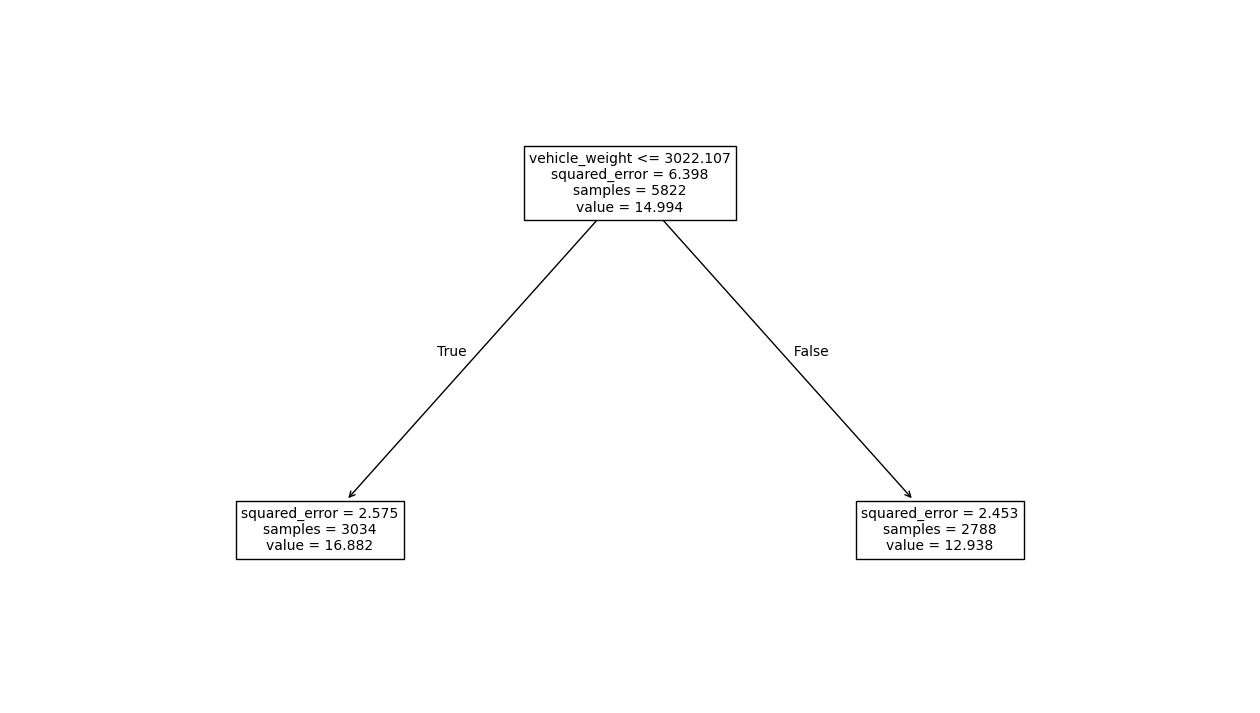

In [27]:
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 9))
plot_tree(dt, feature_names=dv.get_feature_names_out(), fontsize=10)
plt.show()

In [26]:
from sklearn.tree import export_text
print(export_text(dt))

|--- feature_13 <= 3022.11
|   |--- value: [16.88]
|--- feature_13 >  3022.11
|   |--- value: [12.94]



# Question 2 #

In [35]:
from sklearn.ensemble import RandomForestRegressor
 
# n_estimators - number of models we want to use
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [40]:
y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
rmse

0.4586615458484907

# Question 3  #

In [41]:
scores = []
 
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    scores.append((n, rmse))
 
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.458662
1,20,0.453680
2,30,0.451172
3,40,0.448357
4,50,0.446179
5,60,0.445300
6,70,0.444674
7,80,0.444994
8,90,0.445205
9,100,0.444896


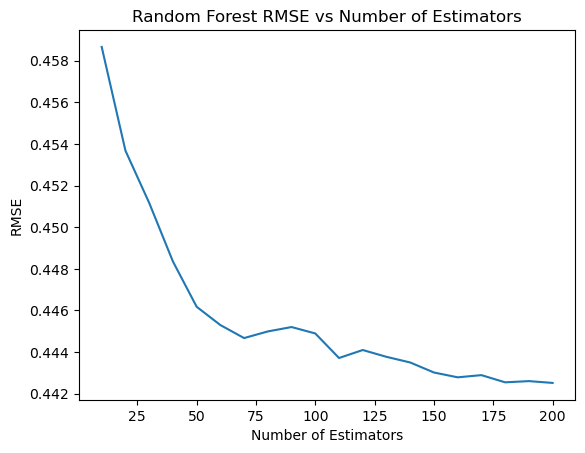

In [42]:
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Random Forest RMSE vs Number of Estimators')
plt.show()

# Question 4 #

In [46]:
scores = []
 
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)

        scores.append((d, n, rmse))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.450627
1,10,20,0.447109
2,10,30,0.445616
3,10,40,0.443237
4,10,50,0.442072


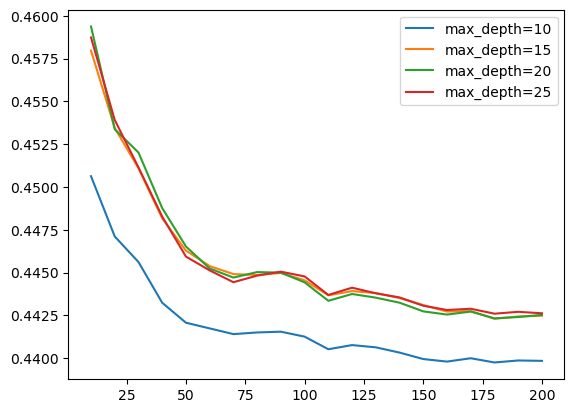

In [48]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]

    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)
 
plt.legend()
plt.show()

# Question 5 #

In [49]:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [50]:
# Random Forest
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

0.45937075026176954

In [51]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance = df_importance[df_importance.gain > 0.01]

In [53]:
df_importance

,feature,gain
13,vehicle_weight,0.959153
6,horsepower,0.016066
0,acceleration,0.011490


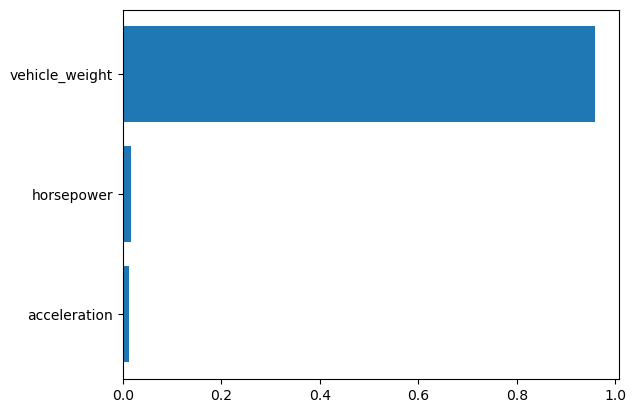

In [52]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

# Question 6 #

In [54]:
import xgboost as xgb

In [55]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [56]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

In [58]:
def parse_xgb_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [59]:
scores = {}

In [60]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

In [61]:
'eta=%s' % (xgb_params['eta'])

'eta=0.3'

In [62]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [63]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
 
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

In [64]:
'eta=%s' % (xgb_params['eta'])

'eta=0.1'

In [65]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

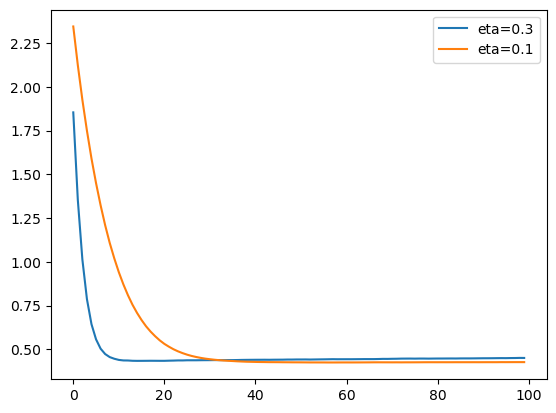

In [72]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)


plt.legend()
plt.show()